# Part 7. DEAP Dataset + CNN1D_LSTM

In this part 7, we shall try to improve the previous part by adding CNN1D before taking LSTM, since CNN1D helps us smoothen the signal.  Consequently, these signals are much smaller in sequence length thus can drastically increase the speed of training. (it is like taking moving average, instead of using raw data).   Also, since these convoluted signals are not only a single point of samples, inputting into LSTM will lead to much greater accuracies.

*Note that we will be only predicting the valence.  Feel free to work on the arousal yourself.*

In this part, most of the code will be the same except 2 Defining Model.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os
import pickle
import numpy as np

Set cuda accordingly.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## 1. Loading dataset

Let's first reuse the dataset loader we have created in Part 1.

In [3]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, path, stim):
        _, _, filenames = next(os.walk(path))
        filenames = sorted(filenames)
        all_data = []
        all_label = []
        for dat in filenames:
            temp = pickle.load(open(os.path.join(path,dat), 'rb'), encoding='latin1')
            all_data.append(temp['data'])
            
            if stim == "Valence":
                all_label.append(temp['labels'][:,:1])   #the first index is valence
            elif stim == "Arousal":
                all_label.append(temp['labels'][:,1:2]) # Arousal  #the second index is arousal
                
        self.data = np.vstack(all_data)[:, :32, ]   #shape: (1280, 32, 8064) --> take only the first 32 channels
        
        shape = self.data.shape
        
        #perform segmentation=====
        segments = 12
        
        self.data = self.data.reshape(shape[0], shape[1], int(shape[2]/segments), segments)
        #data shape: (1280, 32, 672, 12)

        self.data = self.data.transpose(0, 3, 1, 2)
        #data shape: (1280, 12, 32, 672)

        self.data = self.data.reshape(shape[0] * segments, shape[1], -1)
        #data shape: (1280*12, 32, 672)
        #==========================
        
        self.label = np.vstack(all_label) #(1280, 1)  ==> 1280 samples, 
        self.label = np.repeat(self.label, 12)[:, np.newaxis]  #the dimension 1 is lost after repeat, so need to unsqueeze (1280*12, 1)
        
        del temp, all_data, all_label

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        single_data  = self.data[idx]
        single_label = (self.label[idx] > 5).astype(float)   #convert the scale to either 0 or 1 (to classification problem)
        
        batch = {
            'data': torch.Tensor(single_data),
            'label': torch.Tensor(single_label)
        }
        
        return batch

Let's try load the dataset.

In [4]:
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset

In [5]:
dataset = Dataset(path, "Valence")

data  = dataset[:]['data']
label = dataset[:]['label']

print("Data shape: " , data.shape)  #15360 = 32 * 40 trials * 12 segments, 32 EEG channels, 672 samples
print("Label shape: ", label.shape)  #two classes of valence

Data shape:  torch.Size([15360, 32, 672])
Label shape:  torch.Size([15360, 1])


## 2. Defining the Model -> CNN1D_LSTM

By applying CNN1D before LSTM, we are smoothening and downsampling the signals. Performing Conv1d can be easily done by using <code>nn.Conv1d</code>.

Let's first look at how cnn1d process our mockdata.

### I. Understanding CNN1D

In [6]:
mock_batch_size = 2    #in real training, we use 32
mock_input_dim  = 32   #in real data, ours is 32 channels
mock_seq_len    = 10   #in real data, ours is 8064

#note that conv1d wants shape of (batch size, channel, seq len), unlike LSTM which wants (batch size, seq len, channel)
mock_eegdata = torch.rand(mock_batch_size, mock_input_dim, mock_seq_len).to(device)

#define the layer
conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1).to(device)

#execute
conv_mock_eegdata = conv1d(mock_eegdata)

print(conv_mock_eegdata.shape)

torch.Size([2, 32, 8])


As we can see, conv1d runs a window along each channel independently, where the window size is defined by the kernel size.  Imagine a block of 10 (i.e., seq_len=10), we define a window size of 3 that shift to the right one block at a time.  This process of convolution will give us a total of 8 values, thus the out_channel would become 8 after the convolution process.  (I recommend you to try draw it out).

Since some block are not being used equally, we can also add padding to the left and right of this ten block by 1, such convolution will create out_channel to 10 after the convolution process

In [7]:
#adding padding = 1 which adds a empty block on the left and right.
conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1, padding=1).to(device)
conv_mock_eegdata = conv1d(mock_eegdata)
print(conv_mock_eegdata.shape)

torch.Size([2, 32, 10])


There is still one problem, i.e., if we use only kernel size of 3, only three nearby blocks will have some type of interactions.  To model longer-term dependencies, it is also possible to stack convolution layers, so to create some kind of interactions between block1 and farther blocks like block 8.  If you don't see why stacking allows longer-term dependencies, imagine drawing a tree of convolutions.

In [8]:
conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1, padding=1).to(device)

#defining three layers of convolution
conv_mock_eegdata = conv1d(mock_eegdata)
conv_mock_eegdata = conv1d(conv_mock_eegdata)

print(conv_mock_eegdata.shape)

torch.Size([2, 32, 10])


Always recommended to add normalization after convolution and before activation

In [9]:
#define a norm layer with param as the input channel
norm = nn.BatchNorm1d(mock_input_dim).to(device)

conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1, padding=1).to(device)

#adding normalization
conv_mock_eegdata = norm(conv1d(mock_eegdata))
conv_mock_eegdata = norm(conv1d(conv_mock_eegdata))
     
print(conv_mock_eegdata.shape)

torch.Size([2, 32, 10])


Add some activation to add some non-linearities

In [10]:
#define a norm layer with param as the input channel
norm = nn.BatchNorm1d(mock_input_dim).to(device)

conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1, padding=1).to(device)

#adding normalization
conv_mock_eegdata = F.relu(norm(conv1d(mock_eegdata)))
conv_mock_eegdata = F.relu(norm(conv1d(conv_mock_eegdata)))
     
print(conv_mock_eegdata.shape)

torch.Size([2, 32, 10])


Last, to smoothen out noise and obtain a simpler representations, we can use maxpooling, which takes the peak of each window.

In [11]:
#define a norm layer with param as the input channel
norm = nn.BatchNorm1d(mock_input_dim).to(device)

conv1d = nn.Conv1d(mock_input_dim, mock_input_dim, kernel_size=3, stride=1, padding=1).to(device)

#adding pooling
conv_mock_eegdata = F.max_pool1d(F.relu(norm(conv1d(mock_eegdata))), kernel_size=3)
                                     
print(conv_mock_eegdata.shape)  #takes every three blocks and max.  Thus from 10, it becomes 3, ignoring the last block.

torch.Size([2, 32, 3])


### II. Let's define the model

In [12]:
class Conv1D_LSTM(nn.Module):
    '''
    Expected Input Shape: (batch, channels, seq_len)  <==what conv1d wants
    '''
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout):
        super(Conv1D_LSTM, self).__init__()
        self.conv1d = nn.Conv1d(input_dim, input_dim, kernel_size=128, stride=1, padding=1)
        self.norm = nn.BatchNorm1d(input_dim)
        self.lstm = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_layers, output_dim)
        
    def forward(self, x):
        # conv1d expects (batch, channels, seq_len)
        # should not try too big a kernel size, which could lead to too much information loss
        x = F.max_pool1d(F.relu(self.norm(self.conv1d(x))), kernel_size=3)
        x = F.max_pool1d(F.relu(self.norm(self.conv1d(x))), kernel_size=3)

        # change to (batch, seq_len, channels) because lstm expects
        x = x.permute(0,2,1)
        
        #x = [batch size, seq len, channels]
        out, (hn, cn) = self.lstm(x)
        
        #out = [batch size, seq len, hidden dim * num directions]        
        #hn = [num layers * num directions, batch size, hidden dim]
        #cn = [num layers * num directions, batch size, hidden dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

Before we initialize our model, let's also define a function how we want to initialize the network weights.  This is optional.  By default, layers will simply randomize weights but it is always nice to know how we can control weight initialization by defining a function

In [13]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):   #if layer is of Linear
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):   #if layer is of LSTM
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)  #orthogonal is a common way to initialize weights for RNN/LSTM/GRU
    elif isinstance(m, nn.Conv1d):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) #there are really no evidence what works best for convolution, so I just pick one

Let's init the class instance and create a workabout model.

In [14]:
#note that these params are simply obtained from trial and error; I got no theory to back up why I use certain numbers here...
input_dim     = 32 #we got 32 EEG channels
hidden_dim    = 256 #let's define hidden dim as 256
num_layers    = 2  #we gonna have two LSTM layers
output_dim    = 1  #we got 4 classes for our labels
bidirectional = True  #uses bidirectional LSTM
dropout       = 0.5  #setting dropout to 0.5

#define the model
model = Conv1D_LSTM(input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout)

#send to cuda so we can use the GPU
model = model.to(device)  

#apply weights
model.apply(initialize_weights)

Conv1D_LSTM(
  (conv1d): Conv1d(32, 32, kernel_size=(128,), stride=(1,), padding=(1,))
  (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(32, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

Let's also check the number of parameters used

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model Conv1D_LSTM has 2,302,561 trainable parameters


Let's define a simple unit test, inputing some mock EEG data and see whether we got the desired output as 4 classes.

In [16]:
mock_batch_size = 2    #in real training, we use 32
mock_input_dim  = 32   #in real data, ours is 32 channels
mock_seq_len    = 8064 #in real data, ours is 8064

#note that our model first layer is conv1d which expects (batch, channel, seq len)
mock_eegdata = torch.rand(mock_batch_size, mock_input_dim, mock_seq_len).to(device)

#let's try run the model by simply inserting the mockdata into the model; very similar to .fit
predictions = model(mock_eegdata)

#let's try to see the predictions whether it really outputs four unique classes
print("Prediction shape: ", predictions.shape)
print("Predictions: ", predictions)

#simple unit test
assert predictions.shape[0] == mock_batch_size
assert predictions.shape[1] == output_dim

Prediction shape:  torch.Size([2, 1])
Predictions:  tensor([[-0.0621],
        [-0.0098]], device='cuda:0', grad_fn=<AddmmBackward>)


## 3. Training

### I. Batch Iterators

In order to easily loop the dataset, let's create a batch iterator.  The typical steps are:

1.  Split the dataset into training and validation set.
2.  Create a loader using DataLoader APIs

In [17]:
# setting seed so that splitting process and training process can be reproduced
torch.manual_seed(1)

# randomly shuffle the indexes, then randomly select 80% of the data
indices   = torch.randperm(len(dataset)).tolist()
train_ind = int(0.7 * len(dataset))
val_ind   = int(0.9 * len(dataset))

# create subset of dataset
train_set = torch.utils.data.Subset(dataset, indices[:train_ind])
val_set   = torch.utils.data.Subset(dataset, indices[train_ind:val_ind])
test_set  = torch.utils.data.Subset(dataset, indices[val_ind:])

print(f"Full Dataset size:  {len(dataset)}")
print(f"Train Dataset size: {len(train_set)}")
print(f"Valid Dataset size: {len(val_set)}")
print(f"Test Dataset size:  {len(test_set)}\n")

# let's create the loader so we can easily loop each batch for training
params = {"batch_size":16,"shuffle": True,"pin_memory": True}

train_loader = DataLoader(train_set, **params)
val_loader   = DataLoader(val_set, **params)
test_loader  = DataLoader(test_set, **params)

Full Dataset size:  15360
Train Dataset size: 10752
Valid Dataset size: 3072
Test Dataset size:  1536



### II. Optimizers

Optimizer simply refers to the one that gonna take care of the backpropagation process.  The commonly used optimizer is SGD and Adam, both are quite interchangeable.  Here we gonna use Adam.  In order to backpropagate, we gonna define a loss function using cross entropy loss, which is a common loss function for multi-class purposes.

In [18]:
import torch.optim as optim

lr = 0.0001

#can also try SGD which should not make too much of a difference
optimizer = optim.Adam(model.parameters(), lr=lr) 

#combine sigmoid with binary entropy; binary entropy is used for binary classification
criterion = nn.BCEWithLogitsLoss() 

### III. Training procedures

Let's create a function for training, so we can reuse it in the future.  I will write comments where appropriate.

In [19]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [20]:
def train(model, train_loader,  optimizer, criterion):

    model.train()
    epoch_train_loss = 0
    epoch_train_acc  = 0

    for i, batch in enumerate(train_loader):
    
        # data shape: (batch, channel, seq len)
        data  = batch['data'].to(device)    
        # label shape: (batch, 1)
        label = batch['label'].to(device) 
        
        #predict
        output = model(data)  #output shape: (batch, 1)
        loss   = criterion(output, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #for visualizing
        epoch_train_loss += loss.item()
        acc = binary_accuracy(output, label)
        epoch_train_acc += acc.item()
        
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_acc  = epoch_train_acc  / len(train_loader)
    
    return epoch_train_loss, epoch_train_acc

Let's also create another slightly different function to test our model on the validation set.

In [21]:
def evaluate(model, val_loader, criterion):

    model.eval()
    epoch_val_loss = 0
    epoch_val_acc  = 0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            
            # data shape: (batch, channel, seq len)
            data  = batch['data'].to(device)
            label = batch['label'].to(device)
            
            #predict and cal loss
            output = model(data)
            loss   = criterion(output, label)
            
            #for visualizing
            epoch_val_loss += loss.item()
            acc = binary_accuracy(output, label)
            epoch_val_acc += acc.item()
    
    epoch_val_loss =  epoch_val_loss / len(val_loader)
    epoch_val_acc  =  epoch_val_acc  / len(val_loader)
    
    return epoch_val_loss, epoch_val_acc

### IV. Let's train!

Nothing much but simply run the training functions!

In [22]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
best_valid_loss = float('inf')

train_losses = []
train_accs   = []
valid_losses = []
valid_accs   = []

num_epochs = 10

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs  .append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs  .append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/DEAP_CNN_BiLSTM.pt')
        
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f}  |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 7s
	 Train Loss: 0.669 | Train Acc: 57.97%
	 Val. Loss: 0.679  |  Val. Acc: 57.98%
Epoch: 02 | Epoch Time: 0m 8s
	 Train Loss: 0.381 | Train Acc: 82.01%
	 Val. Loss: 0.651  |  Val. Acc: 62.50%
Epoch: 03 | Epoch Time: 0m 7s
	 Train Loss: 0.127 | Train Acc: 94.94%
	 Val. Loss: 0.622  |  Val. Acc: 85.48%
Epoch: 04 | Epoch Time: 0m 7s
	 Train Loss: 0.047 | Train Acc: 98.34%
	 Val. Loss: 0.586  |  Val. Acc: 90.62%
Epoch: 05 | Epoch Time: 0m 9s
	 Train Loss: 0.029 | Train Acc: 99.07%
	 Val. Loss: 0.585  |  Val. Acc: 80.66%
Epoch: 06 | Epoch Time: 0m 8s
	 Train Loss: 0.017 | Train Acc: 99.42%
	 Val. Loss: 0.525  |  Val. Acc: 88.05%
Epoch: 07 | Epoch Time: 0m 7s
	 Train Loss: 0.027 | Train Acc: 99.19%
	 Val. Loss: 0.513  |  Val. Acc: 89.42%
Epoch: 08 | Epoch Time: 0m 7s
	 Train Loss: 0.019 | Train Acc: 99.34%
	 Val. Loss: 0.534  |  Val. Acc: 85.51%
Epoch: 09 | Epoch Time: 0m 7s
	 Train Loss: 0.017 | Train Acc: 99.36%
	 Val. Loss: 0.542  |  Val. Acc: 82.49%
Epoch: 10 

Let's plot the losses and acc for easier inspection

Text(0, 0.5, 'loss')

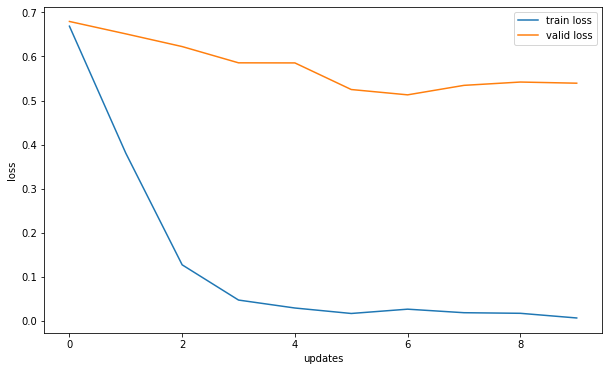

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

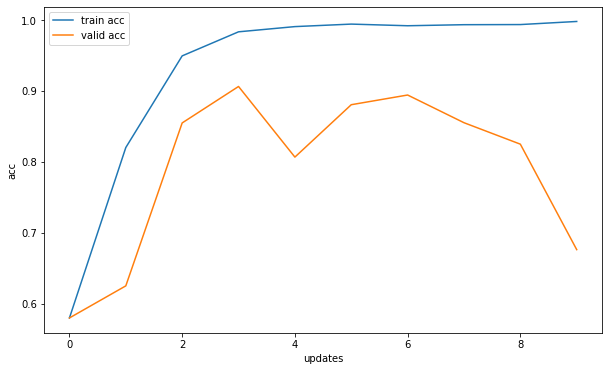

In [25]:
fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

## 4. Evaluation on test set

In [26]:
model.load_state_dict(torch.load('models/DEAP_CNN_BiLSTM.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.511 | Test Acc: 89.39%


## Final Verdict



There are two observations.  

- By performing pooling, it's almost 10 times faster!  That's because LSTM is a very slow model especially if the seq len is very big.  By doing pooling, it downsizes the seq len by almost 10 times, thus the time is also increase dramatically.

- Our accuracy also increases by a lot!  It is clearly because convoluted signals carry more meanings sequentially, thus LSTM was able to learn the patterns.

In the next tutorial, let's try applying attention mechanisms after CNN1D_LSTM, which might help improve accuracy.  I haven't try, so let's see.